# Lineáris regresszió/Bag of words alkalmazása kategorizálásra

## Feladat rövid leírása

A feladat során egy tweet-ből álló adatbázis felhasználásával fogunk különböző feladatokat elvégezni. Elsősorban adattisztitást fogunk végezni az adatbázison, majd numerikussá alakítjuk a vectorunkat. Miután mind ez megvan ezeket a vektorokat gépi tanulási osztályozók bemeneteként használjuk fel.

A célunk, hogy megpróbáljuk helyesen megjósolni a katasztrófákról szóló tweet-eket.

## Készítette:
### Név: Halász Ruben
### Neptun kód: OZNW0Y

### Név:
### Neptun kód: 

## Adatok előkészítése

#### A projekt mükődéséhez feltétlen szükséges könyvtárak

In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

     ---------------------------------------- 7.2/7.2 MB 9.4 MB/s eta 0:00:00
     ---------------------------------------- 55.4/55.4 kB 2.8 MB/s eta 0:00:00
     ------------------------------------- 965.4/965.4 kB 12.2 MB/s eta 0:00:00
     -------------------------------------- 161.3/161.3 kB 9.4 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 11.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install sklearn

  Using cached sklearn-0.0-py2.py3-none-any.whl
     ---------------------------------------- 7.6/7.6 MB 9.5 MB/s eta 0:00:00
     --------------------------------------- 40.2/40.2 MB 10.6 MB/s eta 0:00:00
     -------------------------------------- 298.0/298.0 kB 9.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install nltk


     ---------------------------------------- 1.5/1.5 MB 6.8 MB/s eta 0:00:00
     -------------------------------------- 267.8/267.8 kB 8.3 MB/s eta 0:00:00
     ---------------------------------------- 96.6/96.6 kB 5.8 MB/s eta 0:00:00
     ---------------------------------------- 78.5/78.5 kB 4.5 MB/s eta 0:00:00


In [8]:
pip install gensin

     --------------------------------------- 23.9/23.9 MB 10.7 MB/s eta 0:00:00
     ------------------------------------- 983.8/983.8 kB 12.3 MB/s eta 0:00:00
     ---------------------------------------- 58.6/58.6 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install re

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re


In [15]:
import gensim
import nltk
import sklearn
import pandas as pd
import numpy as np
import matplotlib
import re

### Nyers adat beolvasása

In [10]:
questions = pd.read_csv("data/social_media_clean_text.csv")
questions.columns=['text', 'choose_one', 'class_label']
questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


### Adat tisztitási folyamatok

##### Lekérünk pár információt

In [11]:
questions.tail()

,text,choose_one,class_label
9277,the out of control wild fires in california ...,Relevant,1
9278,police investigating after an e bike collided ...,Relevant,1
9279,the latest more homes razed by northern calif...,Relevant,1
9280,meg issues hazardous weather outlook (hwo),Relevant,1
9281,cityofcalgary has activated its municipal eme...,Relevant,1


In [12]:
questions.describe()

,class_label
count,9282.000000
mean,0.419953
std,0.496190
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


 ##### Adat tisztitás és eredmény megjelenítése

In [19]:
def standardize_text(df, text_field):
    # Mindent át teszünk lowercase-be
    df[text_field] = df[text_field].str.lower()
    # Ennek a segítségével megszabadulunk az URL-től
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"http\S+", "", elem))
    # Ez segitségével megszabadulunk a felesleges pontoktól
    df[text_field]=[re.sub('[^\w\s]+', '', s) for s in df[text_field].tolist()]
    return df

clean_questions = standardize_text(questions, "text")

In [21]:
clean_questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,heard about earthquake is different cities st...,Relevant,1
3,there is a forest fire at spot pond geese are ...,Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [22]:
clean_questions.tail()

,text,choose_one,class_label
9277,the out of control wild fires in california ...,Relevant,1
9278,police investigating after an e bike collided ...,Relevant,1
9279,the latest more homes razed by northern calif...,Relevant,1
9280,meg issues hazardous weather outlook hwo,Relevant,1
9281,cityofcalgary has activated its municipal eme...,Relevant,1


##### Láthatjuk, hogy az osztályaink meglehetősen kiegyensúlyozottak

In [23]:
clean_questions.groupby("class_label").count()

,text,choose_one
class_label,,
0,5396,5396
1,3874,3874
2,12,12


### Kis tokenizáció, hisztogram

Annak érdekében, hogy egy kicsit jobban megismerjük, az adatainkat végezzünk el egy tokenizációt, különálló szavak listájára. Jelenítsük ezt meg egy hisztogram segítségével, amely jobban ábrázolja ezt a folyamatot.

In [25]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

,text,choose_one,class_label,tokens
0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,heard about earthquake is different cities st...,Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,there is a forest fire at spot pond geese are ...,Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [26]:
all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

129933 words total, with a vocabulary size of 17260
Max sentence length is 33


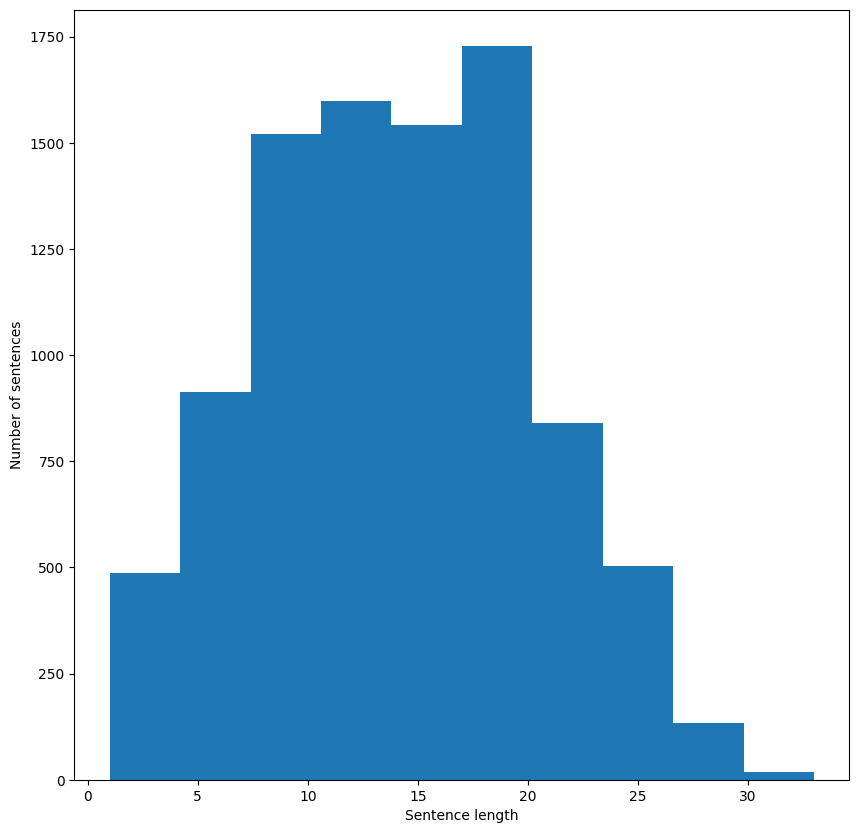

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

### Az adatok train és teszt adathalmazra való bontása

In [28]:
from sklearn.model_selection import train_test_split

list_corpus = clean_questions["text"]
list_labels = clean_questions["class_label"]

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)

print("Training set: %d samples" % len(X_train))
print("Test set: %d samples" % len(X_test))

Training set: 7425 samples
Test set: 1857 samples


In [32]:
print (X_train.loc[:10])

4048    why are you engulfed by low self image take th...
3443     im the one who started it so i feel like i ha...
1863    as long as my  baby is blissfully unaware of t...
7055     people like you should be charged after the i...
5690    fb page of bushman safaris zimbabwe the compan...
                              ...                        
274     to luka they should all die all of them everyt...
745     studying anthrax and bioterrorism before 7 am ...
4531                           that usually never happens
3300    a young heavyweight rapping off of detonate i ...
10       flood  disaster heavy rain causes flash flood...
Name: text, Length: 1092, dtype: object


In [31]:
print (y_train.loc[:10])

4048    0
3443    0
1863    0
7055    0
5690    0
       ..
274     0
745     0
4531    0
3300    0
10      1
Name: class_label, Length: 1092, dtype: int64
